In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from darts import TimeSeries

df = pd.read_csv('../csv/Ming1Jul67_total_order.csv')
df.tail()

,order_completed_at,unique_order_count
543,2024-06-27,145
544,2024-06-28,142
545,2024-06-29,126
546,2024-06-30,161
547,2024-07-01,142


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order_completed_at  548 non-null    object
 1   unique_order_count  548 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ KB


In [4]:
df['order_completed_at'] = pd.to_datetime(df['order_completed_at'])

In [5]:
# make timeseries Object
series = TimeSeries.from_dataframe(df,
                                   time_col='order_completed_at',
                                   value_cols=['unique_order_count'],
                                   freq="D")

# Data preprocessing

In [6]:
# Function to replace outliers with the mean of the rest of the values
from scipy.stats import zscore
from darts import TimeSeries

def replace_outliers_with_mean(df, column_name):
    # Calculate Z-scores
    z_scores = zscore(df[column_name])
    
    # Identify outliers (using a threshold of 3 for Z-score)
    outliers = np.abs(z_scores) > 3
    
    # Calculate mean of non-outliers
    mean_non_outliers = df.loc[~outliers, column_name].mean()
    
    # Replace outliers with the mean of non-outliers
    df.loc[outliers, column_name] = mean_non_outliers
    
    return df

# Replace outliers in 'gmv' column
df_remove_out = replace_outliers_with_mean(df, 'unique_order_count')
series_remove_outlier = TimeSeries.from_dataframe(df_remove_out,
                                   time_col='order_completed_at',
                                   value_cols=['unique_order_count'],
                                   freq="D")
series = series_remove_outlier

C:\Users\User\AppData\Local\Temp\ipykernel_14132\1351848665.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '142.51486988847583' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outliers, column_name] = mean_non_outliers


In [7]:
from darts.dataprocessing.transformers import (Scaler,)

scaler = Scaler()
series_rescaled = scaler.fit_transform(series)
series = series_rescaled

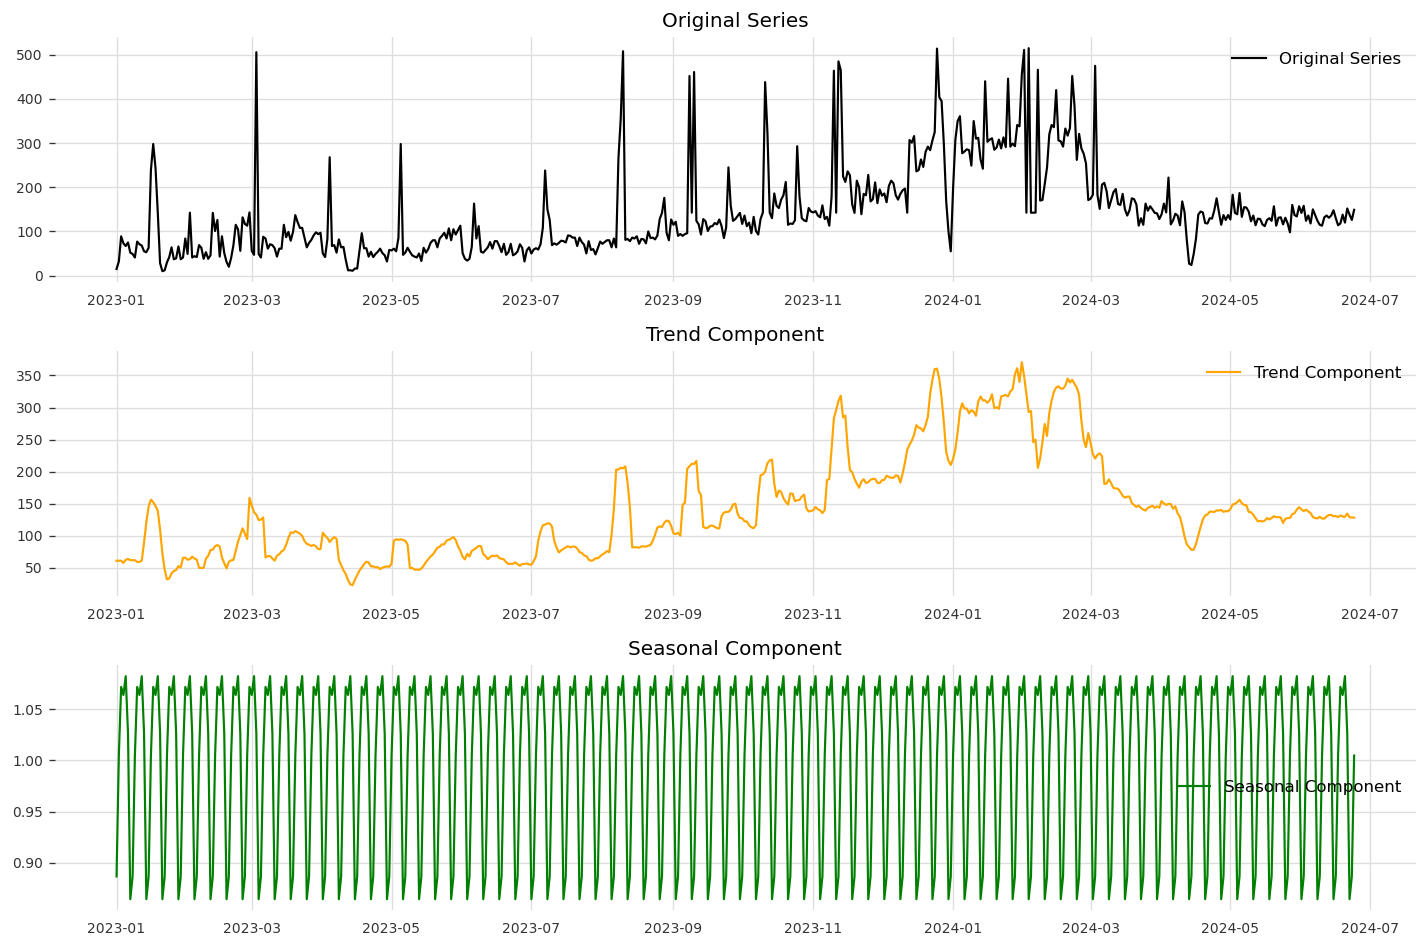

In [9]:
from darts.utils.statistics import extract_trend_and_seasonality
trends , seasonal = extract_trend_and_seasonality(series)


# Plot the results
plt.figure(figsize=(12, 8))

# Original series
plt.subplot(3, 1, 1)
plt.plot(series.time_index, series.values(), label='Original Series')
plt.title('Original Series')
plt.legend()

# Trend component
plt.subplot(3, 1, 2)
plt.plot(trends.time_index, trends.values(), label='Trend Component', color='orange')
plt.title('Trend Component')
plt.legend()

# Seasonal component
plt.subplot(3, 1, 3)
plt.plot(seasonal.time_index, seasonal.values(), label='Seasonal Component', color='green')
plt.title('Seasonal Component')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

### stationary test

#### (MA) moving average

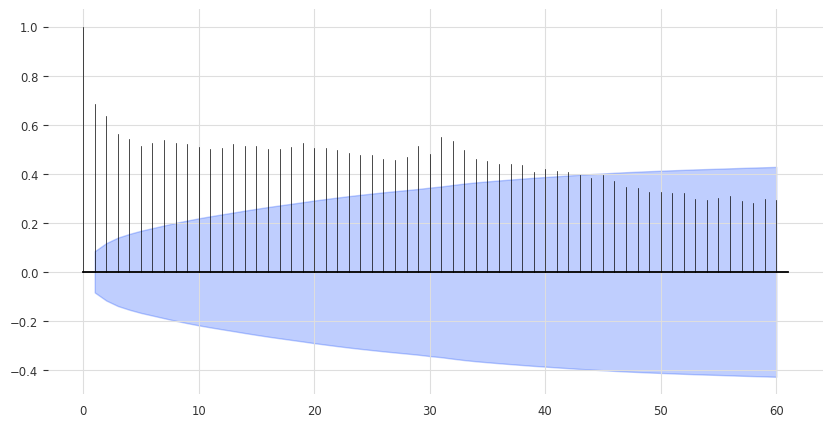

In [9]:
# Plot stationary and also the seasonality using ACF and PACF plots
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_pacf

#test stationary with autocorrelation function
plot_acf(series, max_lag=60)
plt.show()

#กรณีข้อมูลเป็น Stationary จุดในแกน X (lags) มีค่า Y เป็น 0 หรือใกล้เคียง(ค่า Correlation -1,1)

#ARIMA order (p, d, q) ; q = 35 look at lags 35 crossline

In [10]:
# stationary test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["unique_order_count"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
#p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
#https://machinelearningmastery.com/time-series-data-stationary-python/

ADF Statistic: -2.229984
p-value: 0.195543


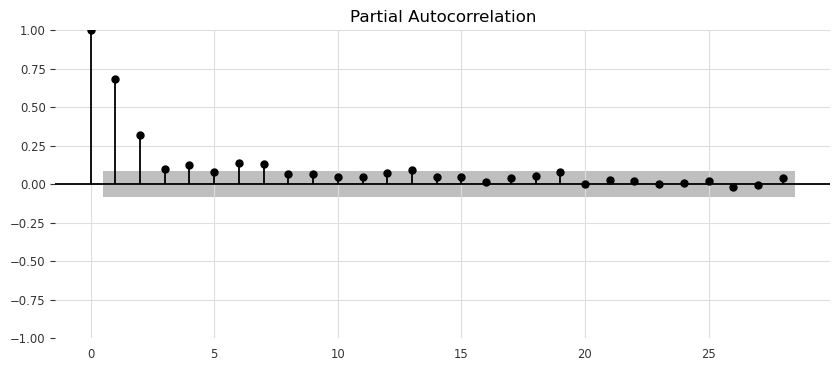

In [11]:
#Auto Regressive (p)
from statsmodels.graphics.tsaplots import  plot_pacf
from statsmodels.tsa.stattools import pacf

plt.rcParams.update({'figure.figsize':(10,4)})
plot_pacf(df['unique_order_count'].dropna(), method = 'ols')
df_pacf = pacf(df['unique_order_count'].dropna(), method = 'ols')

In [17]:
import numpy as np

for i in range(0, len(df_pacf)):
    if df_pacf[i] < (1.96 / np.sqrt(len(df['unique_order_count']))):
        print('p = ', i - 1)
        break

p =  4


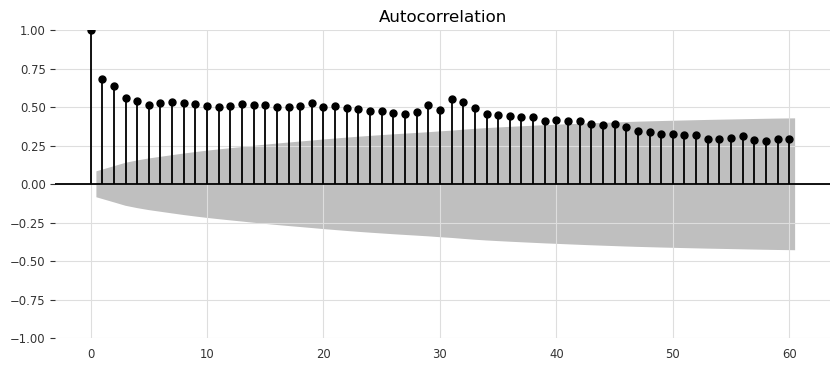

In [22]:
#Moving Average (q)
from statsmodels.graphics.tsaplots import  plot_acf
from statsmodels.tsa.stattools import acf

plt.rcParams.update({'figure.figsize':(10,4)})
plot_acf(df['unique_order_count'], fft = True, lags=60)
df_acf = acf(df['unique_order_count'], fft = True, nlags=60)

In [24]:
for i in range(0, len(df_acf)):
    if df_acf[i] < (1.96 / np.sqrt(len(df['unique_order_count']))):
        print('q=', i - 1)
        break

0.08426698175690016


In [8]:
# training, validation =series.split_before(pd.Timestamp('2024-01-01'))
# training, validation =series.split_before(0.9)
cut_off = pd.Timestamp('2024-05-01')
training, validation =series.split_before(cut_off) # 1 month
# training, validation =series.split_before(pd.Timestamp('2024-04-01')) # 2 month

In [9]:
#check date split
validation_df = validation.pd_dataframe()
training_df = training.pd_dataframe()
print(training_df.tail())
print(validation_df.head())
print(training_df.shape)
print(validation_df.shape)

component           unique_order_count
order_completed_at                    
2024-04-26                    0.265347
2024-04-27                    0.207921
2024-04-28                    0.251485
2024-04-29                    0.229703
2024-04-30                    0.251485
component           unique_order_count
order_completed_at                    
2024-05-01                    0.231683
2024-05-02                    0.342574
2024-05-03                    0.261386
2024-05-04                    0.255446
2024-05-05                    0.350495
(486, 1)
(62, 1)


In [25]:
from darts.models.forecasting.arima import ARIMA
from darts.metrics import mape, mae, mse, mase
from math import sqrt

parameters = {
    "q": [0,1,2,3,4,5],
    "p":[0,1,2,3,4,5],
    "d":[0]
}

best_parameter = ARIMA.gridsearch(
    parameters=parameters,
    series = series, 
    start=cut_off,
    forecast_horizon=7,
    stride=1,          
    last_points_only=False,  
    metric=mse,
    verbose=-1
)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Us

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\anaconda3\envs\conda_dart\

In [11]:
from darts.models.forecasting.arima import ARIMA
from darts.metrics import mape, mae, mse, mase
from math import sqrt

best_model = ARIMA(q=2, p=4, d=0)
best_model.fit(training)

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(p=4, d=0, q=2, seasonal_order=(0, 0, 0, 0), trend=None, random_state=None, add_encoders=None)

In [26]:
print(best_parameter)

(ARIMA(p=1, d=0, q=0, seasonal_order=(0, 0, 0, 0), trend=None, random_state=None, add_encoders=None), {'q': 0, 'p': 1, 'd': 0}, 0.003029663992867215)


In [27]:
best_model = best_parameter[0]
best_model.fit(training)

ARIMA(p=1, d=0, q=0, seasonal_order=(0, 0, 0, 0), trend=None, random_state=None, add_encoders=None)

In [36]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt

backtest_errors = best_model.backtest(
     series,
     start=pd.Timestamp('2024-05-01'),          # เริ่มต้นที่ 90% ของข้อมูล
     forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
     stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
     last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่
     metric=mse,
     reduction=np.mean           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
)
print(f'backtest_errors MSE: {backtest_errors}')

backtest_errors MSE: 311.09517953569326


In [43]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt

backtest_errors = best_model.backtest(
     series,
     start=pd.Timestamp('2024-05-01'),          # เริ่มต้นที่ 90% ของข้อมูล
     forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
     stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
     last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่
     metric=mape,
     reduction=np.mean           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
)
print(f'backtest_errors MAPE: {backtest_errors}')

backtest_errors MAPE: 10.672647053757757


In [12]:
# result from training , validation only
prediction = best_model.predict(len(validation))

mape_score = mape(validation, prediction)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation, prediction)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation, prediction)
print(f'score MAE: {round(mae_score, 4)}')

score MAPE: 10.4076
score ACC: 89.5924
score MSE: 0.0012
score RMSE: 0.0353
score MAE: 0.0268


In [13]:
validation_rescale = scaler.inverse_transform(validation)
prediction_rescale = scaler.inverse_transform(prediction)

mape_score = mape(validation_rescale, prediction_rescale)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation_rescale, prediction_rescale)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation_rescale, prediction_rescale)
print(f'score MAE: {round(mae_score, 4)}')

score MAPE: 9.6417
score ACC: 90.3583
score MSE: 318.4149
score RMSE: 17.8442
score MAE: 13.5236


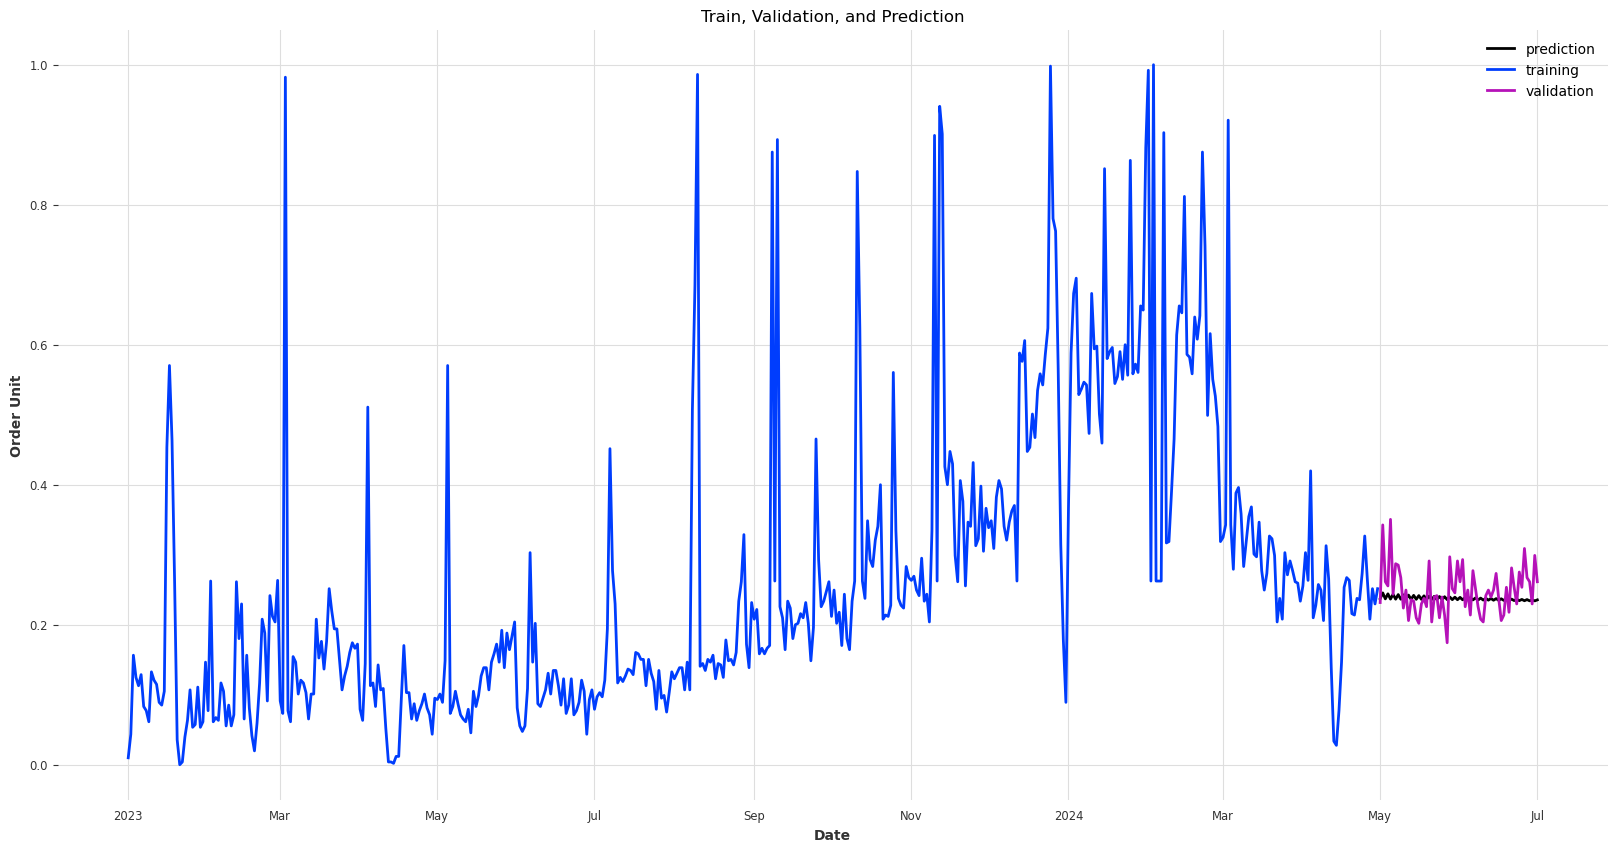

In [14]:
plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)
##prediction
prediction.plot(label="prediction")
training.plot(label="training")
validation.plot(label="validation")

plt.legend()
plt.title('Train, Validation, and Prediction')
plt.xlabel('Date')
plt.ylabel('Order Unit')
plt.show()

In [15]:
# predict future
best_model.fit(series)

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(p=4, d=0, q=2, seasonal_order=(0, 0, 0, 0), trend=None, random_state=None, add_encoders=None)

In [17]:
from darts.models import ARIMA
# best_model = ARIMA.load("../model/ARIMA_Model_totalOrder_25Jun67.pkl")

forecast = best_model.predict(7)
forecast  = scaler.inverse_transform(forecast)
forecast = forecast.pd_dataframe().reset_index()
forecast.columns = ['Date', 'Total Order']
print(forecast.tail(7))

forecast.tail(7).to_csv('../forecast/Date_ARIMA.csv', index=False)

        Date  Total Order
0 2024-07-02   139.244054
1 2024-07-03   141.412619
2 2024-07-04   136.102161
3 2024-07-05   140.303365
4 2024-07-06   135.456630
5 2024-07-07   139.776716
6 2024-07-08   135.308758


In [18]:
best_model.save("../model/ARIMA_Model_totalOrder_1Jul67.pkl")

# ARIMA find order

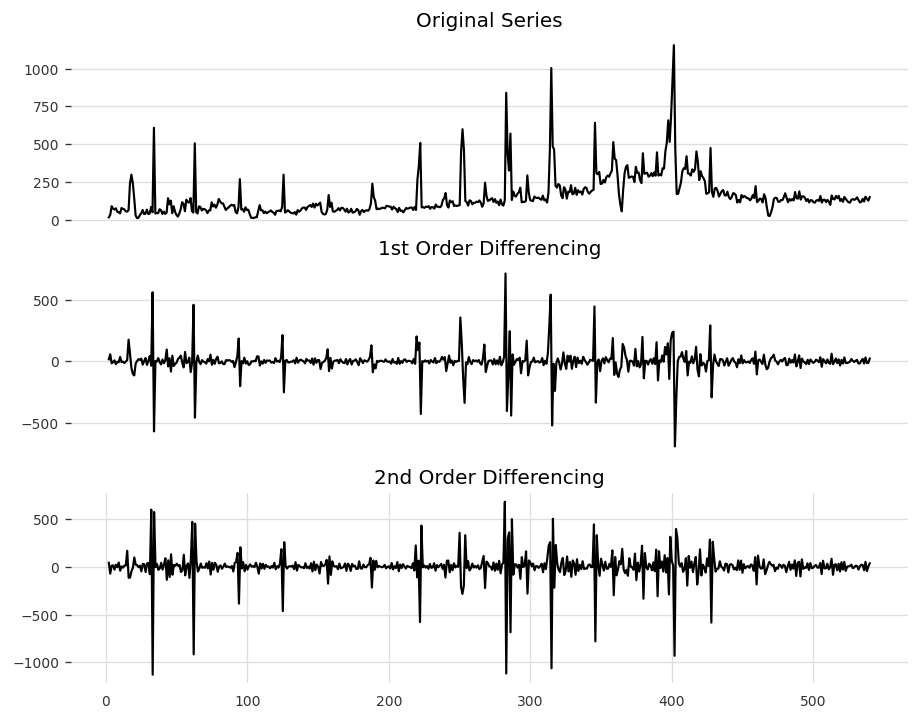

In [16]:
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt 
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120}) 
#Original Series 
fig, (ax1, ax2, ax3) = plt.subplots(3) 
ax1.plot(df['unique_order_count']); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False) 
# 1st Differencing 
ax2.plot(df['unique_order_count'].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False) 
# 2nd Differencing 
ax3.plot(df['unique_order_count'].diff().diff()); ax3.set_title('2nd Order Differencing') 
plt.show()


In [18]:
# stationary test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["unique_order_count"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
#p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
#https://machinelearningmastery.com/time-series-data-stationary-python/

ADF Statistic: -2.984690
p-value: 0.036349


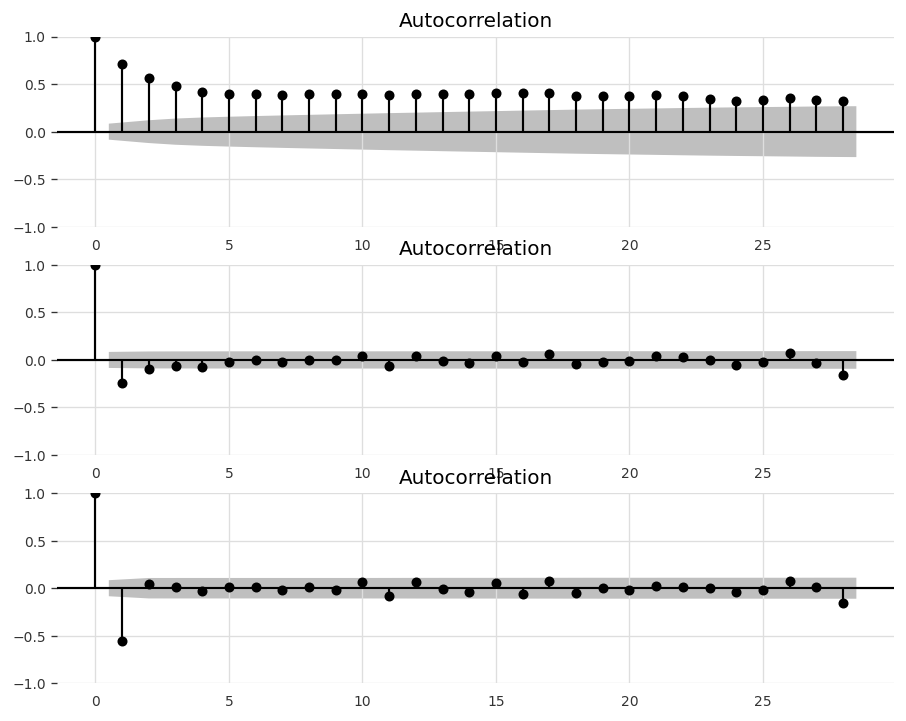

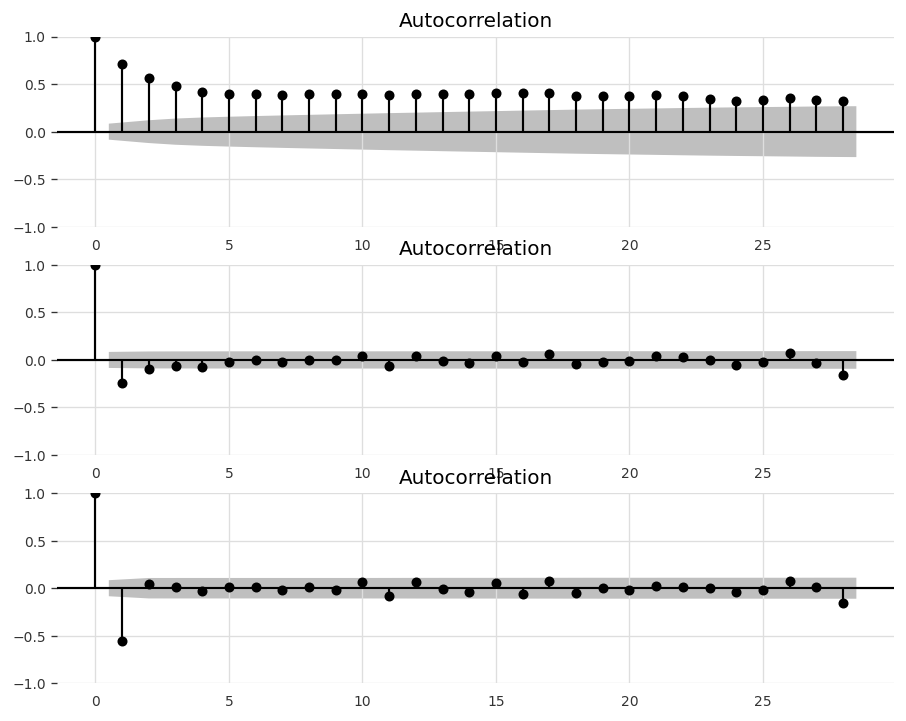

In [21]:
from statsmodels.graphics.tsaplots import plot_acf 
fig, (ax1, ax2, ax3) = plt.subplots(3) 
plot_acf(df['unique_order_count'], ax=ax1) 
plot_acf(df['unique_order_count'].diff().dropna(), ax=ax2) 
plot_acf(df['unique_order_count'].diff().diff().dropna(), ax=ax3)


In [ ]:
plot_acf(df['unique_order_count'].diff().dropna())

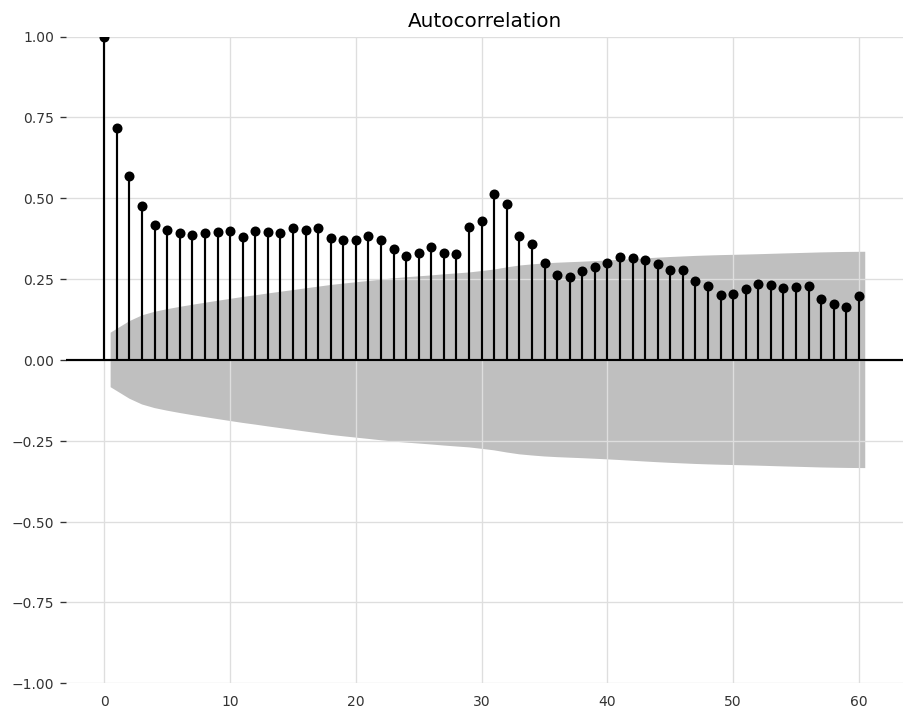

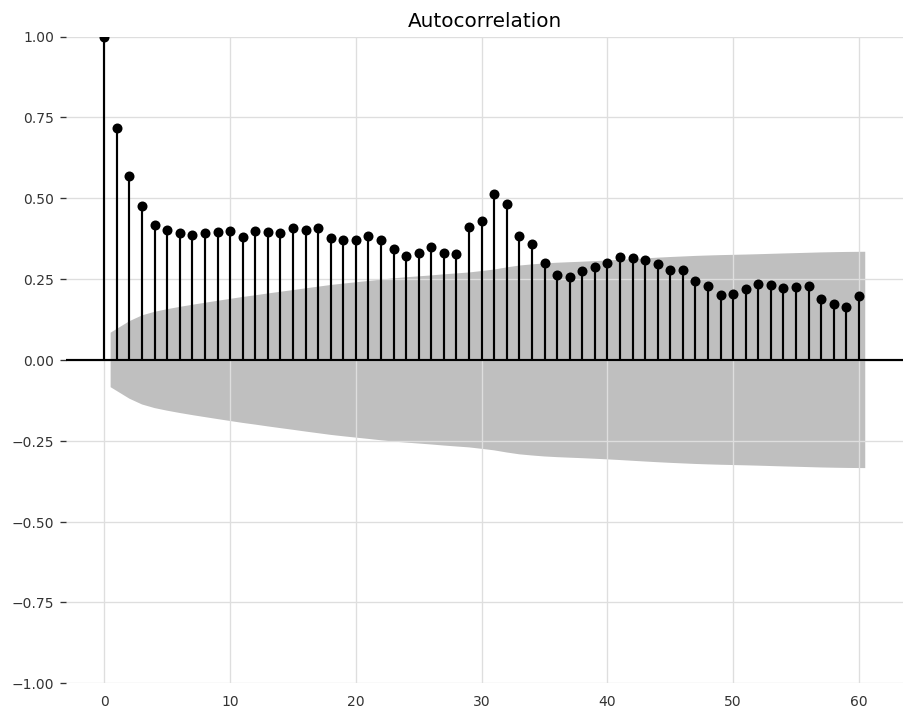

In [24]:
plot_acf(df['unique_order_count'].dropna(), lags=60)

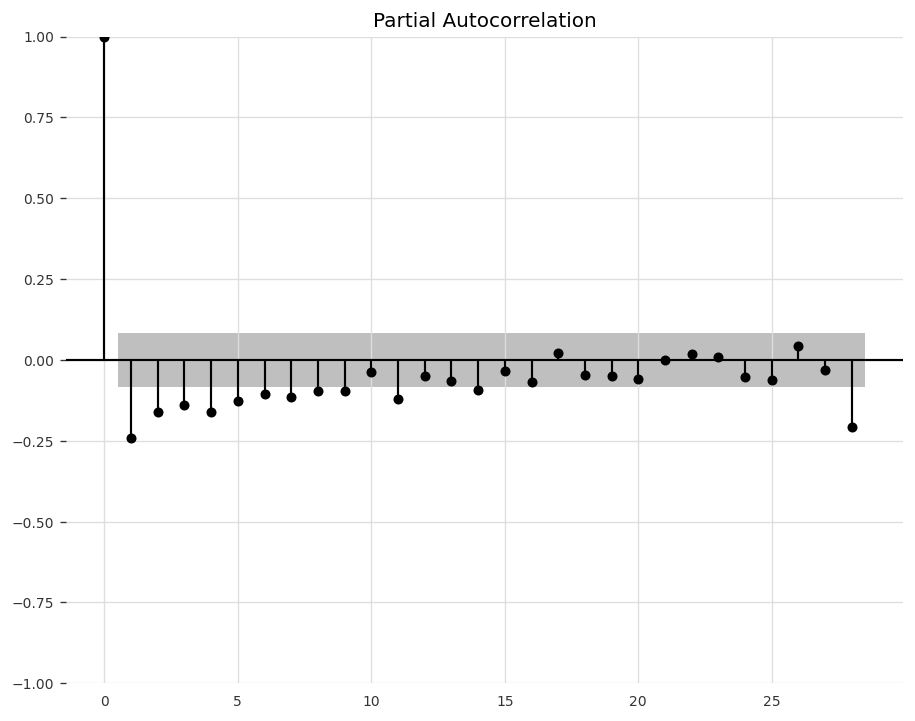

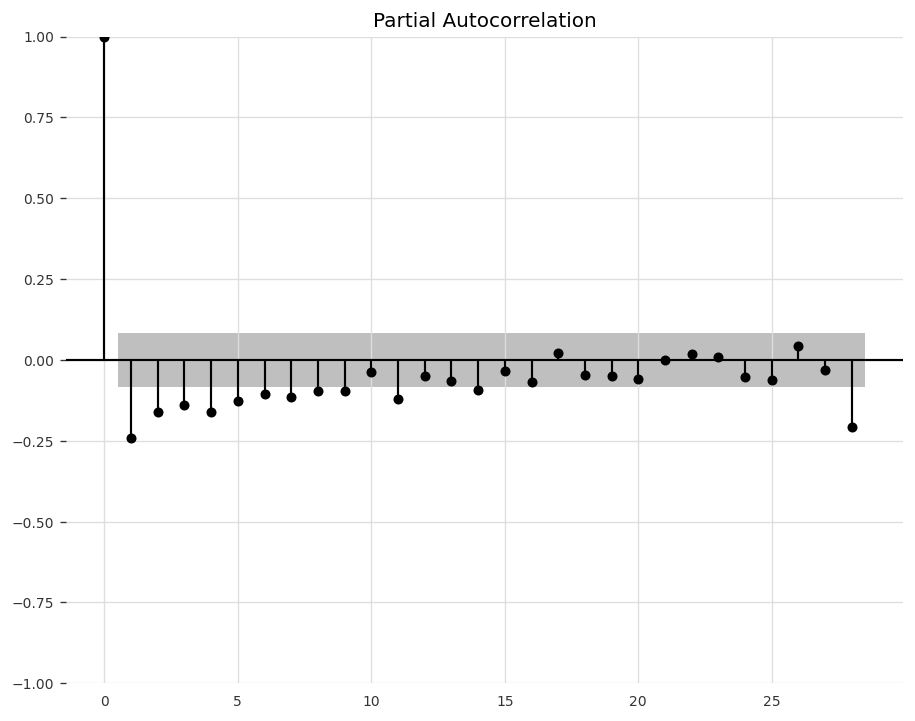

In [25]:
from statsmodels.graphics.tsaplots import plot_pacf 
plot_pacf(df['unique_order_count'].diff().dropna())


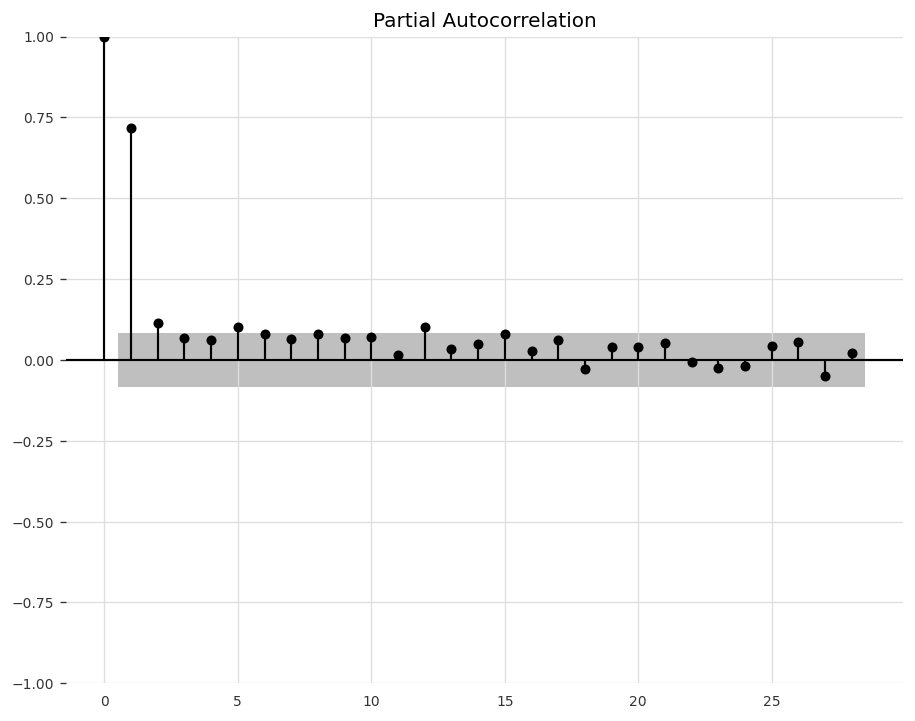

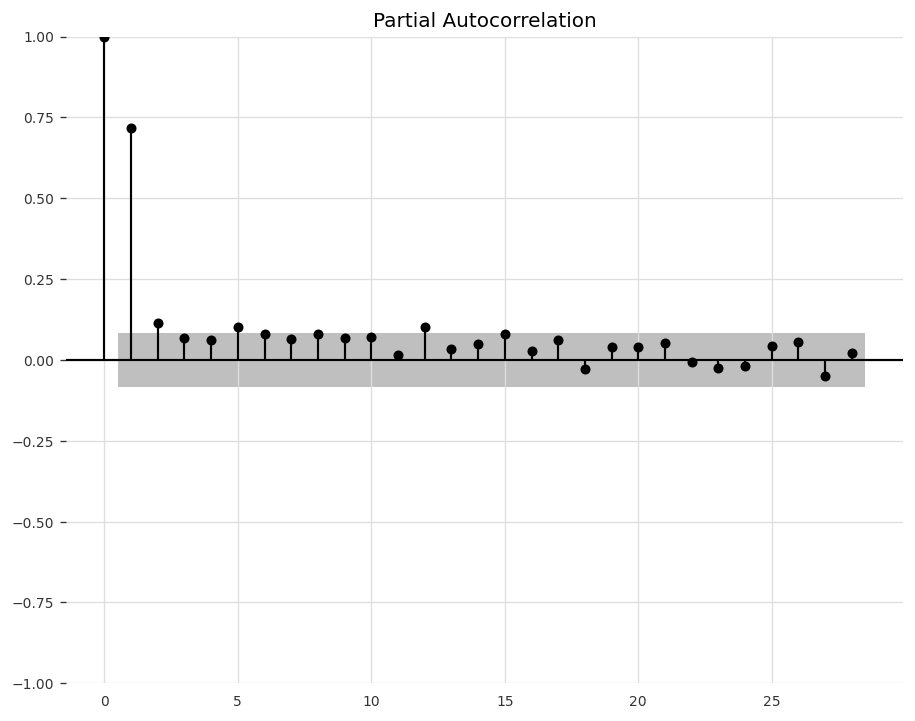

In [26]:
plot_pacf(df['unique_order_count'].dropna())